IMPORTS

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spotipy
from spotipy.oauth2 import SpotifyOAuth
from spotipy.oauth2 import SpotifyClientCredentials
import lyricsgenius
from textblob import TextBlob
from langdetect import detect
from bs4 import BeautifulSoup
import re
from nltk.tokenize import word_tokenize
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

EXPLORATORY DATA ANALYSIS

In [3]:
stream_hist = pd.read_json("StreamingHistory0.json")
stream_hist["endTime"] = pd.to_datetime(stream_hist['endTime'])
stream_hist.head()

,endTime,artistName,trackName,msPlayed
0,2022-12-07 12:26:00,Muse,Supremacy,32140
1,2022-12-07 12:30:00,Against The Current,Wildfire - LEC Version,189940
2,2022-12-07 12:33:00,Against The Current,Roses,217760
3,2022-12-07 12:37:00,Against The Current,Sweet Surrender,212506
4,2022-12-07 12:40:00,Against The Current,Almost Forgot - Stripped Live,204488


In [4]:
stream_hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7360 entries, 0 to 7359
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   endTime     7360 non-null   datetime64[ns]
 1   artistName  7360 non-null   object        
 2   trackName   7360 non-null   object        
 3   msPlayed    7360 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 230.1+ KB


In [5]:
print("Number of the different artists have been listened in last years",len(stream_hist.artistName.unique()))

Number of the different artists have been listened in last years 891


Top 5 artists listened throughout the year:
artistName
Dolu Kadehi Ters Tut    1046
Duman                    535
Sezen Aksu               166
Sertab Erener            131
Sıla                     116
Name: count, dtype: int64


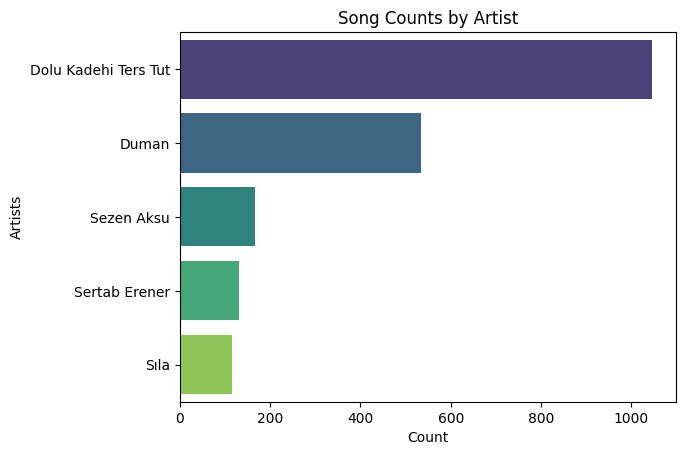

In [6]:
print("Top 5 artists listened throughout the year:")
seri =stream_hist.artistName.value_counts().head()
print(seri)

sns.barplot(x=seri.values, y=seri.index, palette='viridis')

# Add labels and title
plt.xlabel('Count')
plt.ylabel('Artists')
plt.title('Song Counts by Artist')

# Show the plot
plt.show()


In [7]:
devices = pd.read_json("SearchQueries.json")

devices.head()

,platform,searchTime,searchQuery,searchInteractionURIs
0,IPHONE,2023-09-11T15:34:07.315Z[UTC],aynen,[spotify:track:52iLGA0dTV5Nk1TXGbRrUH]
1,IPHONE,2023-09-12T15:38:50.039Z[UTC],hiç,"[spotify:track:2w5SV2BYwU4FVKBkFYlCU2, spotify..."
2,IPHONE,2023-09-12T15:39:02.764Z[UTC],27,[spotify:track:5bm6xzrdhAoBgLQ51n2E4B]
3,IPHONE,2023-09-12T19:35:43.942Z[UTC],gitme,[spotify:track:4Sng3wnol2Gb2yXgFdr9lj]
4,OSX_ARM64,2023-09-15T13:28:57.834Z[UTC],olmadı,[]


In [8]:
devices.platform.value_counts()

platform
IPHONE          89
OSX_ARM64       59
                58
IPHONE_ARM64    27
Name: count, dtype: int64

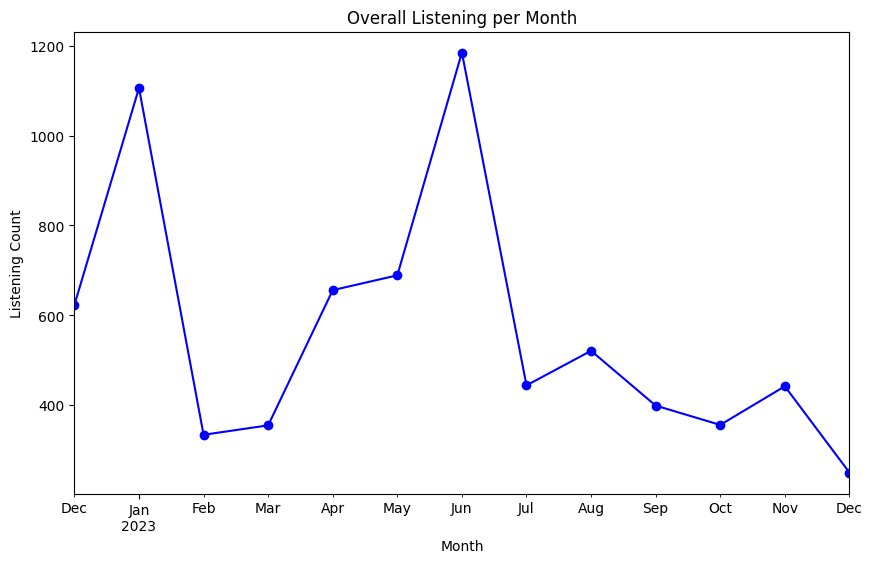

In [9]:
stream_hist["Month"] = stream_hist['endTime'].dt.to_period('M')
monthly_listening = stream_hist.groupby('Month').size()
plt.figure(figsize=(10, 6))
monthly_listening.plot(kind='line', marker='o', color='b')

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Listening Count')
plt.title('Overall Listening per Month')

# Show the plot
plt.show()

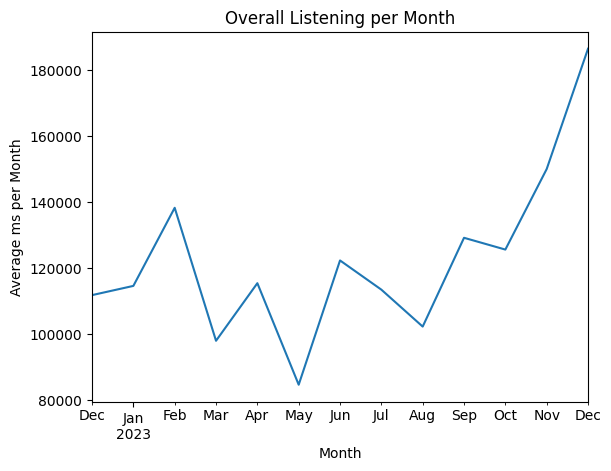

In [10]:
average_ms_per_month = stream_hist.groupby('Month')['msPlayed'].mean()
average_ms_per_month.plot()

plt.xlabel('Month')
plt.ylabel('Average ms per Month')
plt.title('Overall Listening per Month')

# Show the plot
plt.show()

In [11]:
most_frequent_artist_per_month = stream_hist.groupby(['Month', 'artistName']).size().groupby('Month').idxmax().apply(lambda x: x[1])

most_frequent_artist_per_month


Month
2022-12    Dolu Kadehi Ters Tut
2023-01              Sezen Aksu
2023-02    Dolu Kadehi Ters Tut
2023-03    Dolu Kadehi Ters Tut
2023-04    Dolu Kadehi Ters Tut
2023-05    Dolu Kadehi Ters Tut
2023-06    Dolu Kadehi Ters Tut
2023-07    Dolu Kadehi Ters Tut
2023-08                   Duman
2023-09    Dolu Kadehi Ters Tut
2023-10                   Duman
2023-11    Dolu Kadehi Ters Tut
2023-12    Dolu Kadehi Ters Tut
Freq: M, dtype: object

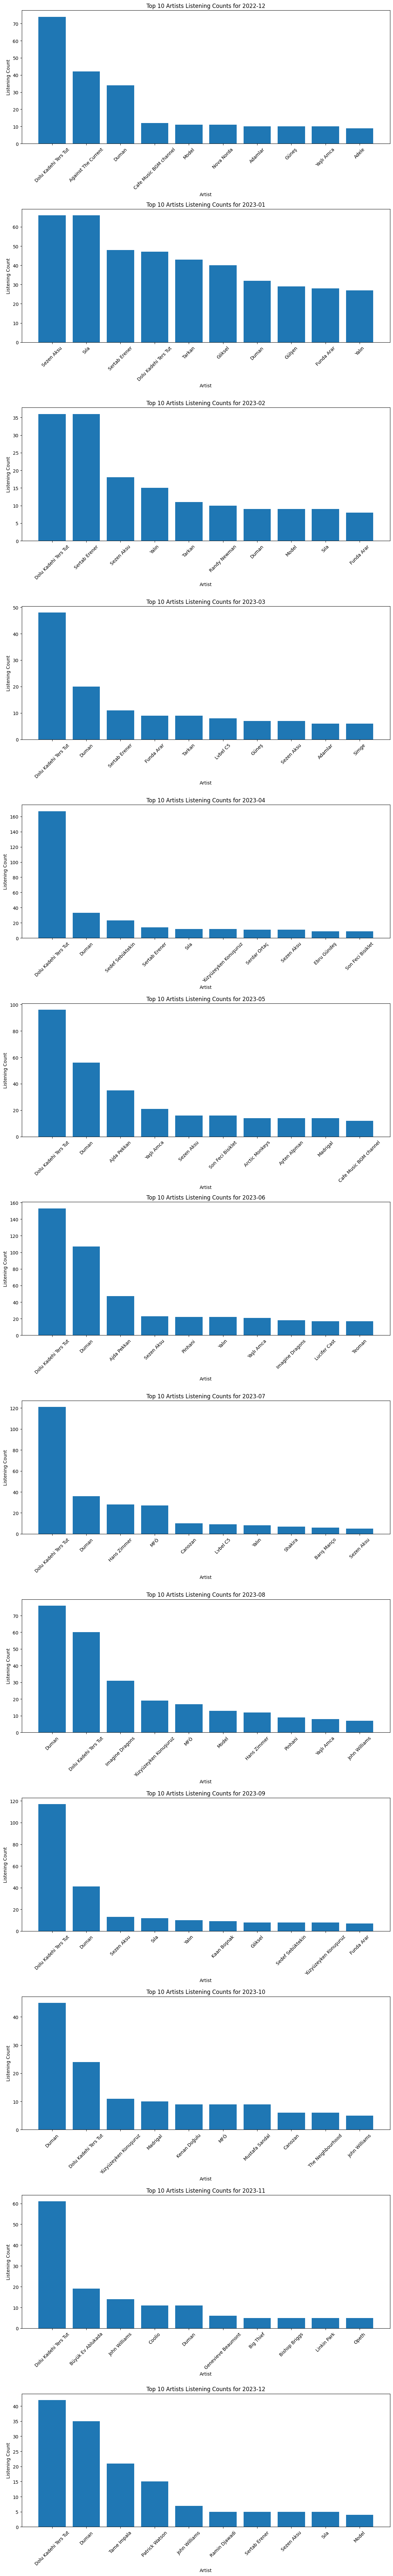

In [12]:
top10_artists_per_month = stream_hist.groupby(['Month', 'artistName']).size().groupby('Month', group_keys=False).nlargest(10).reset_index(name='listening_count')

# Plotting
fig, axs = plt.subplots(nrows=len(top10_artists_per_month['Month'].unique()), figsize=(12, 6 * len(top10_artists_per_month['Month'].unique())))

for i, (month, data_month) in enumerate(top10_artists_per_month.groupby('Month')):
    axs[i].bar(data_month['artistName'], data_month['listening_count'])
    axs[i].set_xlabel('Artist')
    axs[i].set_ylabel('Listening Count')
    axs[i].set_title(f'Top 10 Artists Listening Counts for {month}')
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [13]:
SPOTIPY_CLIENT_ID = '5fad718e1df54db798b592cde648d60e'
SPOTIPY_CLIENT_SECRET = '042214e16ad443158d400d266a84b6d3'
SPOTIPY_REDIRECT_URI = 'https://localhost:6000/callback'

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=SPOTIPY_CLIENT_ID,
                                               client_secret=SPOTIPY_CLIENT_SECRET,
                                               redirect_uri=SPOTIPY_REDIRECT_URI,
                                               scope='user-library-read'))

unique_artists = stream_hist['artistName'].unique()

# Fetch genre information for each artist
artist_genres = {}
for artist in unique_artists:
    results = sp.search(q='artist:' + artist, type='artist')
    if results['artists']['items']:
        artist_info = results['artists']['items'][0]
        genres = artist_info.get('genres', [])
        artist_genres[artist] = ', '.join(genres)
    else:
        artist_genres[artist] = None

# Add genre information to the dataframe
stream_hist['genres'] = stream_hist['artistName'].map(artist_genres)





In [14]:
pd.to_pickle(stream_hist, "genres appended")

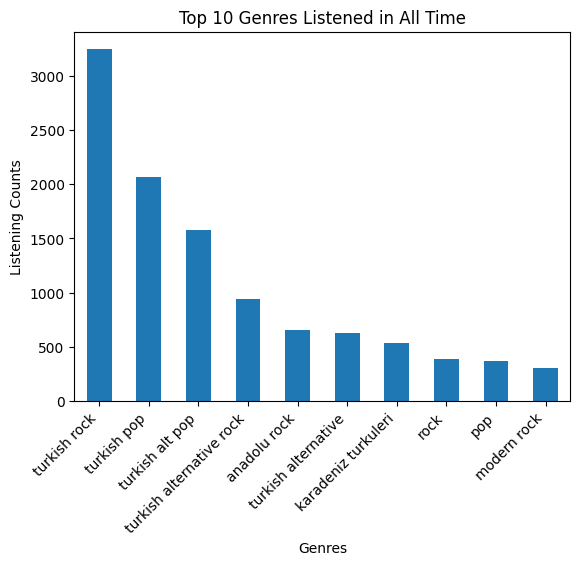

In [15]:
dummy=stream_hist.copy()
dummy = dummy.dropna(how="any")

genre_data = []
for index, row in dummy.iterrows():
    genres = row['genres'].split(', ')
    for genre in genres:
        genre_data.append({'Title': row['trackName'], 'Genre': genre})


expanded_df = pd.DataFrame(genre_data)


# Calculate the frequency of each genre
genre_counts = expanded_df['Genre'].value_counts()

# Get the top 10 most frequent genres
genre_counts.head(10).plot(kind="bar")

plt.xlabel("Genres")
plt.ylabel("Listening Counts")
plt.title("Top 10 Genres Listened in All Time")
plt.xticks(rotation=45, ha="right")
plt.show()

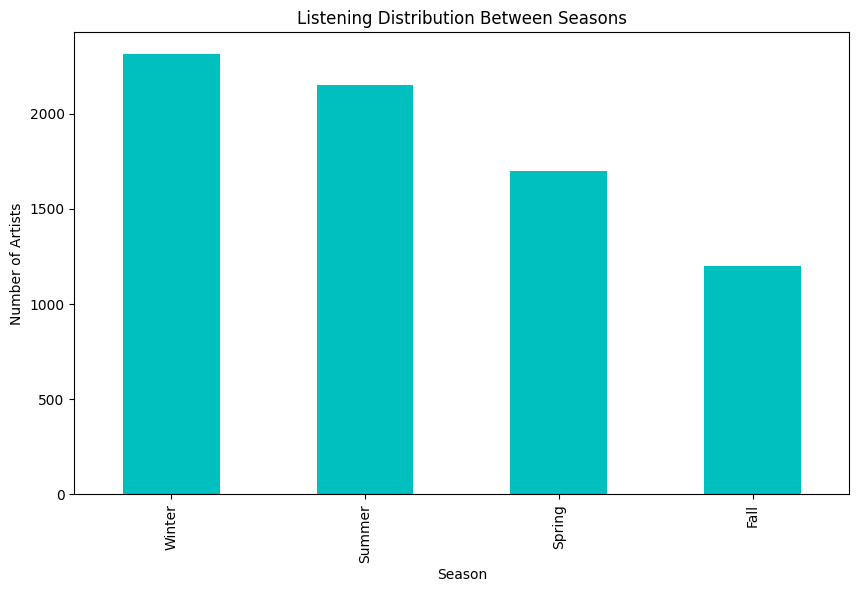

In [16]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

stream_hist['season'] = stream_hist['endTime'].dt.month.apply(get_season)

# Group by season and calculate the count of unique artists
seasonal_artist_distribution = stream_hist.season.value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
seasonal_artist_distribution.plot(kind='bar', color='c')

# Add labels and title
plt.xlabel('Season')
plt.ylabel('Number of Artists')
plt.title('Listening Distribution Between Seasons')

# Show the plot
plt.show()


In [17]:
most_common_artists_by_season = stream_hist.groupby(['season', 'artistName']).size().reset_index(name='count')\
    .sort_values(['season', 'count'], ascending=[True, False])\
    .groupby('season').first()

print("Most common artist in each season:")
print(most_common_artists_by_season)



Most common artist in each season:
                  artistName  count
season                             
Fall    Dolu Kadehi Ters Tut    202
Spring  Dolu Kadehi Ters Tut    311
Summer  Dolu Kadehi Ters Tut    334
Winter  Dolu Kadehi Ters Tut    199


SENTIMENT ANALYSIS ON LYRICS

In [87]:

GENIUS_API_TOKEN = 'DVcrNQy5VR4T8BQhQR4ZBcMhMfT6aSB1QttNXERJN59oNqARx1C4hGv5vsE9z4y1'
genius = lyricsgenius.Genius(GENIUS_API_TOKEN,timeout=10)

df_unique_songs = stream_hist.drop_duplicates(subset=['artistName', 'trackName']).reset_index(drop=True)

def get_lyrics(artist, song):
    try:
        # Search for lyrics on Genius
        song_obj = genius.search_song(song, artist)
        return song_obj.lyrics
    except Exception as e:
        print(f"Error fetching lyrics for {artist} - {song}: {e}")
        return None

# Add a new column for lyrics in the dataframe
df_unique_songs['lyrics'] = df_unique_songs.apply(lambda row: get_lyrics(row['artistName'], row['trackName']), axis=1)

# Print or save the dataframe with lyrics
df_unique_songs.head()


Searching for "Supremacy" by Muse...
Done.
Searching for "Wildfire - LEC Version" by Against The Current...
Done.
Searching for "Roses" by Against The Current...
Done.
Searching for "Sweet Surrender" by Against The Current...
Done.
Searching for "Almost Forgot - Stripped Live" by Against The Current...
Done.
Searching for "Almost Forgot" by Against The Current...
Done.
Searching for "In Our Bones" by Against The Current...
Done.
Searching for "Closer, Faster" by Against The Current...
Done.
Searching for "Demons" by Against The Current...
Done.
Searching for "Wasteland" by Against The Current...
Done.
Searching for "Running with the Wild Things" by Against The Current...
Done.
Searching for "Young & Relentless" by Against The Current...
Done.
Searching for "Wildfire" by Against The Current...
Done.
Searching for "Comeback Kid" by Against The Current...
Done.
Searching for "Friendly Reminder" by Against The Current...
Done.
Searching for "Another You (Another Way)" by Against The Curren

,endTime,artistName,trackName,msPlayed,Month,genres,season,lyrics
0,2022-12-07 12:26:00,Muse,Supremacy,32140,2022-12,"alternative rock, modern rock, permanent wave,...",Winter,33 ContributorsSupremacy Lyrics[Instrumental I...
1,2022-12-07 12:30:00,Against The Current,Wildfire - LEC Version,189940,2022-12,"neon pop punk, pixie, pop punk",Winter,5 ContributorsWildfire (LEC Version) Lyrics[Ve...
2,2022-12-07 12:33:00,Against The Current,Roses,217760,2022-12,"neon pop punk, pixie, pop punk",Winter,11 ContributorsRoses Lyrics[Verse 1]\nWaited a...
3,2022-12-07 12:37:00,Against The Current,Sweet Surrender,212506,2022-12,"neon pop punk, pixie, pop punk",Winter,8 ContributorsSweet Surrender Lyrics[Verse 1]\...
4,2022-12-07 12:40:00,Against The Current,Almost Forgot - Stripped Live,204488,2022-12,"neon pop punk, pixie, pop punk",Winter,4 ContributorsAnabasis LyricsBOOK I\n\nDarius ...


In [95]:

df_unique_songs = df_unique_songs.dropna(how="any")
def clean_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

df_unique_songs['lyrics'] = df_unique_songs['lyrics'].apply(clean_html_tags)


/var/folders/44/5yg4cgkd4pg391k837c7m3lw0000gn/T/ipykernel_51062/2527201363.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


In [97]:


def remove_special_characters(text):
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

df_unique_songs['lyrics'] = df_unique_songs['lyrics'].apply(remove_special_characters)

In [100]:
df_unique_songs['lyrics'] = df_unique_songs['lyrics'].str.lower()

In [105]:


df_unique_songs['lyrics'] = df_unique_songs['lyrics'].apply(word_tokenize)

In [18]:
deneme = pd.read_pickle("keep")

In [19]:
deneme['lyrics'] = deneme['lyrics'].apply(lambda x: x[5:-5] if len(x) > 5 else [])

In [20]:
deneme.head()

,endTime,artistName,trackName,msPlayed,Month,genres,season,lyrics,language
0,2022-12-07 12:26:00,Muse,Supremacy,32140,2022-12,"alternative rock, modern rock, permanent wave,...",Winter,"[wake, to, see, your, true, emancipation, is, ...",ro
1,2022-12-07 12:30:00,Against The Current,Wildfire - LEC Version,189940,2022-12,"neon pop punk, pixie, pop punk",Winter,"[1, chrissy, costanza, they, say, it, started,...",en
2,2022-12-07 12:33:00,Against The Current,Roses,217760,2022-12,"neon pop punk, pixie, pop punk",Winter,"[all, night, for, you, to, come, home, i, alwa...",et
3,2022-12-07 12:37:00,Against The Current,Sweet Surrender,212506,2022-12,"neon pop punk, pixie, pop punk",Winter,"[echo, in, the, dark, you, called, out, my, na...",af
4,2022-12-07 12:40:00,Against The Current,Almost Forgot - Stripped Live,204488,2022-12,"neon pop punk, pixie, pop punk",Winter,"[and, parysatis, had, two, son, the, elder, wa...",en


In [21]:
def detokenize_text(tokens):
    return ' '.join(tokens)

# Apply detokenization to the 'tokens' column
deneme['lyrics'] = deneme['lyrics'].apply(detokenize_text)

In [22]:
def detect_language(text):
    try:
        return detect(text) if text else None
    except Exception as e:
        print(f"Error detecting language: {e}")
        return None

# Add a new column for language detection in the dataframe
deneme['language'] = deneme['lyrics'].apply(detect_language)


In [30]:


model = AutoModelForSequenceClassification.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
sa= pipeline("sentiment-analysis", tokenizer=tokenizer, model=model)



config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/263k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [36]:
#only english languages are accurate because i couldnt find any turkish models that can read an entire lyric of a song.
#so i only get the first 512 characters of a turkish song
def perform_sentiment_analysis(text, language):
    if language == 'en':
        blob = TextBlob(text)
        return blob.sentiment.polarity
    elif language =='tr':
        p = sa(text[:512])
        return p[0]["score"]
    else:
        return None
    
deneme['sentiment'] = deneme.apply(lambda row: perform_sentiment_analysis(row['lyrics'], row['language']), axis=1)

<Axes: xlabel='season'>

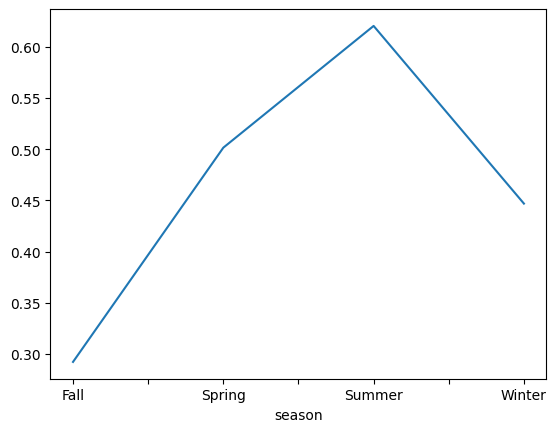

In [40]:
deneme.groupby("season")["sentiment"].mean().plot(kind="line")

<Axes: xlabel='Month'>

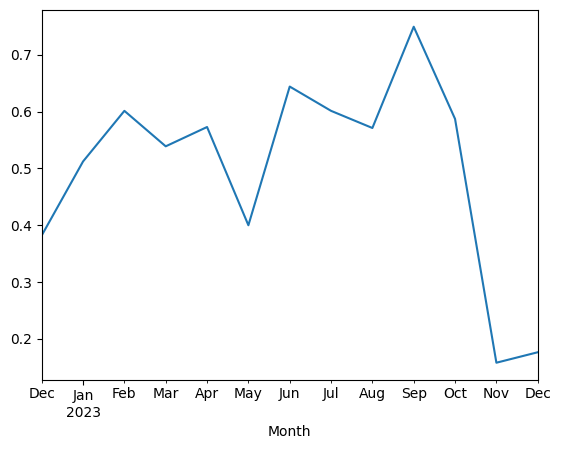

In [59]:
deneme.groupby("Month")["sentiment"].mean().plot()

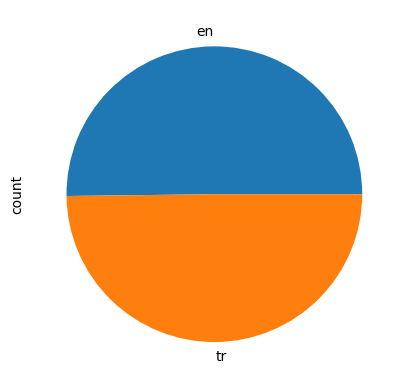

In [58]:
deneme[(deneme.language == "en") | (deneme.language == "tr")].language.value_counts().plot(kind="pie")
plt.show()